In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import seaborn as sns
import emcee as emcee
from scipy import optimize



In [30]:
gal_csv=pd.read_csv('/home/kevin/aufklarung_astro_station/project2/sqlgalaxy_table.csv')
gal_csv.columns


# Better cleaning of data to remove outliers
exclude_columns=["specObjID", "class", "subClass", "ra", "dec", "mjd"]
gal_csv_exc=gal_csv.drop(columns=exclude_columns)


gal_csv_exc= gal_csv_exc[ (gal_csv_exc
						 <= 
						 10*gal_csv_exc.median())
						  &
						  (gal_csv_exc 
						 >= 
						 -10*gal_csv_exc.median())  ]

gal_csv_exc.fillna(0,inplace=True)


In [31]:
column1=gal_csv_exc["oh_p50"].to_numpy()
column2=gal_csv_exc["lgm_tot_p50"].to_numpy()


In [32]:
def color_mass_model(column1, a, b):
    """
    Model function for color-mass relationship (linear example).

    Args:
        mass (np.ndarray): Array of galaxy masses.
        a (float): Slope parameter.
        b (float): Intercept parameter.

    Returns:
        np.ndarray: Array of predicted colors based on the model.
    """

    return a * column1 + b

def log_likelihood(theta, x, y, sigma):
    """
    Calculates the log-likelihood of the model given the data.

    Args:
        theta (tuple): Model parameters (e.g., slope, intercept).
        x (np.ndarray): Array of independent variables (mass).
        y (np.ndarray): Array of dependent variables (color).
        sigma (float): Standard deviation of the noise (optional).

    Returns:
        float: Log-likelihood value.
    """

    model = color_mass_model(x, *theta)
    # Assuming Gaussian noise
    sigma = sigma if sigma is not None else 1.0  # Set default sigma if not provided
    return -0.5 * np.sum(((y - model) / sigma) ** 2)



def log_prior(theta):
    """
    Defines a prior probability distribution for the model parameters (optional).

    Args:
        theta (tuple): Model parameters.

    Returns:
        float: Log-prior probability, or 0.0 if outside prior range.
    """

    a, b = theta
    if -10 < a < 10 and -0.5 < b < 0.5:  # Example uniform prior for a and b
        return 0.0
    else:
        return -np.inf


def log_probability(theta, x, y, sigma):
    """
    Combines the log-likelihood and log-prior (if applicable).

    Args:
        theta (tuple): Model parameters.
        x (np.ndarray): Array of independent variables (mass).
        y (np.ndarray): Array of dependent variables (color).
        sigma (float): Standard deviation of the noise (optional).

    Returns:
        float: Total log probability (log-likelihood + log-prior).
    """

    log_like = log_likelihood(theta, x, y, sigma)
    if np.isinf(log_like):
        return -np.inf
    log_prior_value = log_prior(theta) if log_prior is not None else 0.0
    return log_like + log_prior_value



In [33]:
# Define initial guess (you might want to try different guesses)
nwalkers = 200  # Number of walkers (MCMC chains)
ndim = 2  # Number of fitting parameters (slope and intercept)
p0 = np.random.rand(nwalkers, ndim) * (2 * np.random.rand(ndim) - 1) + 1  # Random initial positions in prior range


In [34]:
# Run MCMC using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(column1, column2, 1.0))
sampler.run_mcmc(p0, 1000)  # Run for 1000 steps (adjust as needed)


/home/kevin/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 1.18020633 -0.48550043]
 [ 1.17433558 -0.45734639]
 [ 1.18107898 -0.48607058]
 [ 1.17228648 -0.39556515]
 [ 1.17324635 -0.4453801 ]
 [ 1.18000985 -0.46029575]
 [ 1.17773653 -0.48076512]
 [ 1.17277716 -0.44307826]
 [ 1.17303039 -0.44572486]
 [ 1.15720235 -0.27707617]
 [ 1.17724323 -0.48210842]
 [ 1.17474776 -0.46376602]
 [ 1.17649511 -0.48890576]
 [ 1.17562343 -0.46830931]
 [ 1.18086271 -0.49584185]
 [ 1.17685815 -0.46491838]
 [ 1.17216935 -0.41467422]
 [ 1.16930284 -0.40389735]
 [ 1.181292   -0.49258956]
 [ 1.17813389 -0.48384337]
 [ 1.16813373 -0.36667336]
 [ 1.18008486 -0.47861537]
 [ 1.17949155 -0.47738855]
 [ 1.18080906 -0.49801098]
 [ 1.1780435  -0.48934084]
 [ 1.17801292 -0.49462753]
 [ 1.17156722 -0.41700022]
 [ 1.17040678 -0.42412951]
 [ 1.17587775 -0.45090398]
 [ 1.17956586 -0.48922511]
 [ 1.17535299 -0.44198162]
 [ 1.1717018  -0.43122987]
 [ 1.17889331 -0.47299894]
 [ 1.17925699 -0.47377536]
 [ 1.17339678 -0.45489029]
 [ 1.17837161 -0.46759567]
 [ 1.16291236 -0.37275

In [35]:
# Get chain samples for further analysis
samples = sampler.chain[:, :, :].reshape((-1, ndim))

mle_result = optimize.minimize(lambda theta: -log_probability(theta, column1, column2,1.0),
                                 samples[np.argmax(sampler.flatchain[:, 0])])  # Use best point from chain



/home/kevin/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/kevin/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [36]:

mean_params = np.mean(samples, axis=0)
median_params = np.median(samples, axis=0)
std_params = np.std(samples, axis=0)
print("Fitting parameters (slope, intercept):")
print(f"Mean: {mean_params}")
print(f"Median: {median_params}")
print(f"Standard Deviation: {std_params}")


Fitting parameters (slope, intercept):
Mean: [ 1.17432842 -0.41675773]
Median: [ 1.17744007 -0.47147328]
Standard Deviation: [0.01828084 0.21101074]


/tmp/ipykernel_15510/2395319510.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


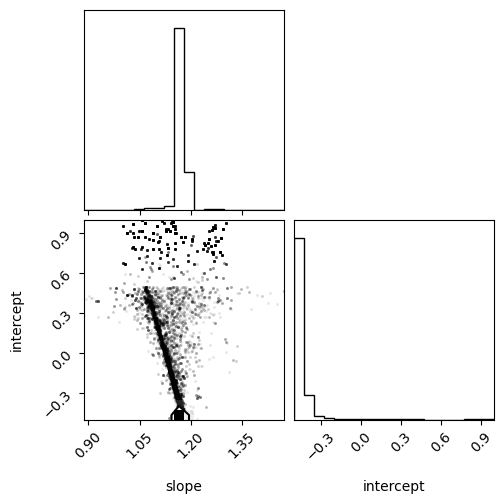

In [37]:
import corner
# Create the corner plot
fig = corner.corner(samples, labels=["slope", "intercept"])  # Replace labels with actual parameter names
fig.show()

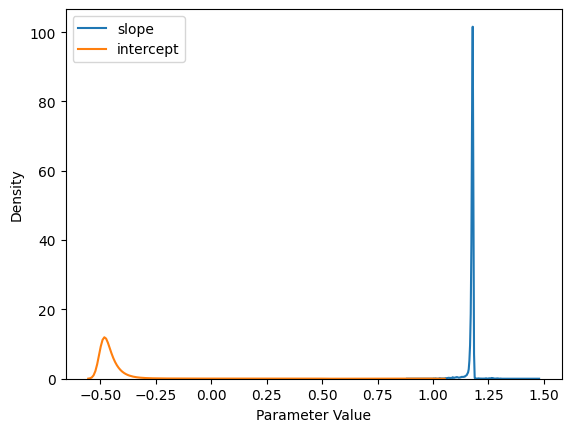

In [38]:
import seaborn as sns

# Assuming you have your MCMC chain samples in 'samples'

# Create the KDE plot for each parameter
sns.kdeplot(samples[:, 0], label="slope")  # Replace index with actual parameter index
sns.kdeplot(samples[:, 1], label="intercept")  # Replace index with actual parameter index
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [27]:
mle_result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 300179256.02486616
        x: [-3.034e-01  4.997e-01]
      nit: 0
      jac: [-5.640e+02 -1.068e+03]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 21
     njev: 3

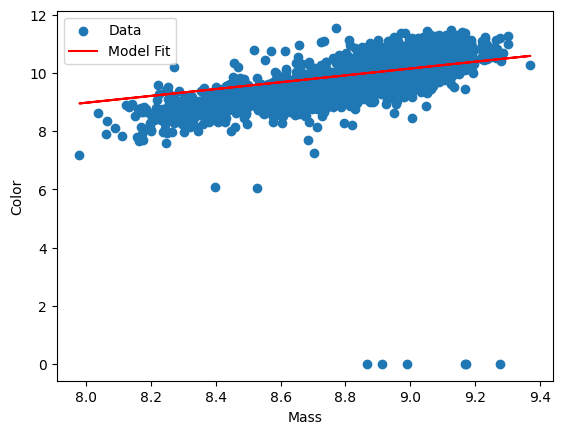

In [39]:
predicted_color = color_mass_model(column1, mean_params[0], mean_params[1])
import matplotlib.pyplot as plt

plt.scatter(column1, column2, label='Data')
plt.plot(column1, predicted_color, color='red', label='Model Fit')
plt.xlabel('color')
plt.ylabel('mass')
plt.legend()
plt.show()